In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from pandas import DataFrame
from pandas import Grouper
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [3]:
# data imported
data=pd.read_csv('Book1.csv',header=0, index_col=0, parse_dates=True)

# EDA & Preprocessing

In [5]:
#shape
data.shape

(42, 1)

In [6]:
data.head()

,inflation_rate
year,
1980-01-01,11.346
1981-01-01,12.654
1982-01-01,7.736
1983-01-01,12.558
1984-01-01,6.517


# Upsampling data Yearly to Monthly

In [7]:
upsampled = data.resample('M').mean()
print(upsampled.head(24))

            inflation_rate
year                      
1980-01-31          11.346
1980-02-29             NaN
1980-03-31             NaN
1980-04-30             NaN
1980-05-31             NaN
1980-06-30             NaN
1980-07-31             NaN
1980-08-31             NaN
1980-09-30             NaN
1980-10-31             NaN
1980-11-30             NaN
1980-12-31             NaN
1981-01-31          12.654
1981-02-28             NaN
1981-03-31             NaN
1981-04-30             NaN
1981-05-31             NaN
1981-06-30             NaN
1981-07-31             NaN
1981-08-31             NaN
1981-09-30             NaN
1981-10-31             NaN
1981-11-30             NaN
1981-12-31             NaN


In [8]:
# interplote null value
interpolated = upsampled.interpolate(method='linear')
print(interpolated.head(24))


            inflation_rate
year                      
1980-01-31       11.346000
1980-02-29       11.455000
1980-03-31       11.564000
1980-04-30       11.673000
1980-05-31       11.782000
1980-06-30       11.891000
1980-07-31       12.000000
1980-08-31       12.109000
1980-09-30       12.218000
1980-10-31       12.327000
1980-11-30       12.436000
1980-12-31       12.545000
1981-01-31       12.654000
1981-02-28       12.244167
1981-03-31       11.834333
1981-04-30       11.424500
1981-05-31       11.014667
1981-06-30       10.604833
1981-07-31       10.195000
1981-08-31        9.785167
1981-09-30        9.375333
1981-10-31        8.965500
1981-11-30        8.555667
1981-12-31        8.145833


In [9]:
# export new montly data file
interpolated.to_csv('Inflation Rate  (montly).csv',index=True)

In [10]:
interpolated.describe()

,inflation_rate
count,493.000000
mean,7.615614
std,2.762229
min,3.428000
25%,4.977250
50%,7.675250
75%,9.833333
max,13.483000


In [11]:
# checking null values
interpolated.isnull().sum()

inflation_rate    0
dtype: int64

In [12]:
# getting information
interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 1980-01-31 to 2021-01-31
Freq: M
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   inflation_rate  493 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB


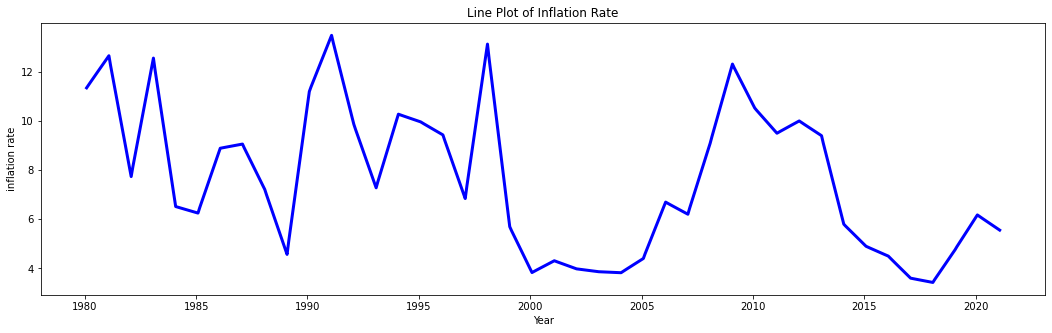

In [13]:
# line plot
plt.figure(figsize=(18,5))
plt.plot(interpolated['inflation_rate'], color = 'blue', linewidth=3)
plt.xlabel('Year')
plt.ylabel('inflation rate')
plt.title ("Line Plot of Inflation Rate")
plt.show()

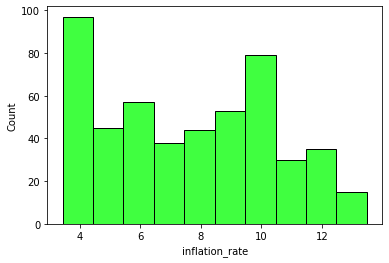

In [14]:
# histplot
sns.histplot(data=interpolated, x="inflation_rate", color="lime")
plt.show()

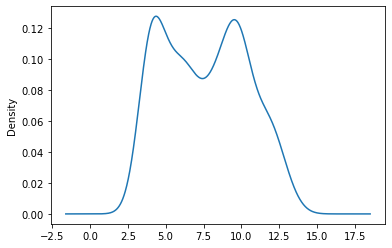

In [15]:
# Distplot
interpolated.inflation_rate.plot(kind='kde')
plt.show()

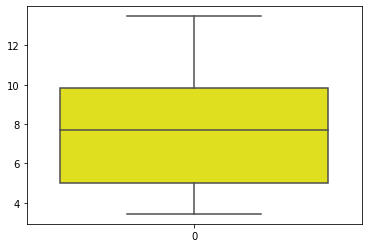

In [16]:
# boxplot
sns.boxplot(data=interpolated['inflation_rate'],color='yellow')
plt.show()

<Figure size 1296x360 with 0 Axes>

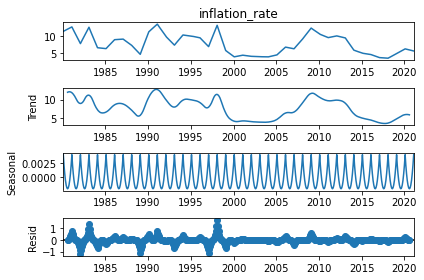

In [17]:
# seasonal decompose graph
plt.figure(figsize=(18,5))
decompose_ts_add = seasonal_decompose(interpolated.inflation_rate,period=12)
decompose_ts_add.plot()
plt.show()

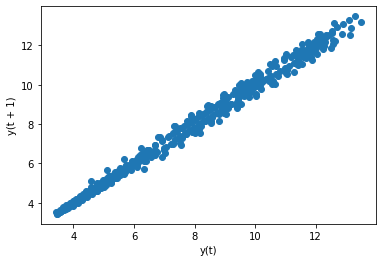

In [18]:
# 1step lag graph
lag_plot(interpolated.inflation_rate)
plt.show()

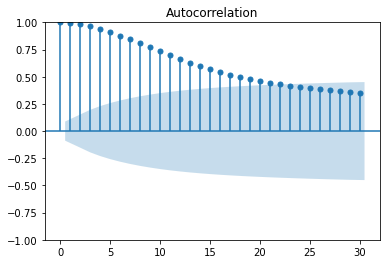

In [19]:
# auto corelation plot
plot_acf(interpolated.inflation_rate,lags=30)
plt.show()

In [2]:
data=pd.read_csv('Inflation Rate  (montly).csv',header=0)

In [41]:
# creating some features for model based approach
data['t']=np.arange(1,(len(data)+1))
data['t_square']=data['t']*data['t']
data['log_rate']=np.log(data['inflation_rate'])
data['year_'] = pd.to_datetime(data['year']).dt.year
data['month'] = pd.to_datetime(data['year']).dt.month_name()


In [42]:
data.head()

,year,inflation_rate,t,t_square,log_rate,year_,month
0,1980-01-31,11.346,1,1,2.428865,1980,January
1,1980-02-29,11.455,2,4,2.438426,1980,February
2,1980-03-31,11.564,3,9,2.447897,1980,March
3,1980-04-30,11.673,4,16,2.457278,1980,April
4,1980-05-31,11.782,5,25,2.466573,1980,May


<AxesSubplot:xlabel='month', ylabel='year_'>

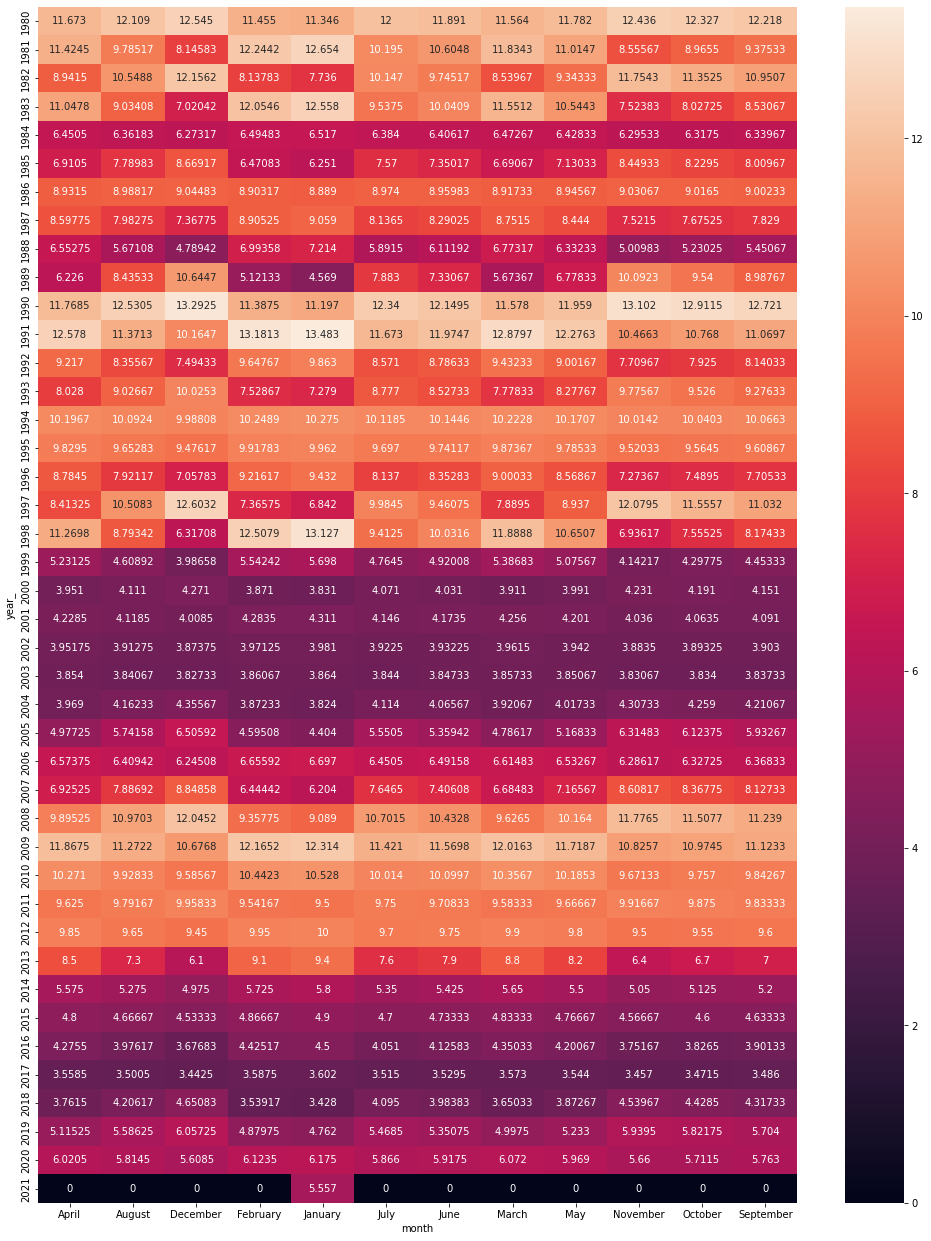

In [43]:
# heat map of month and year
plt.figure(figsize=(17,22))
heatmap_y_month = pd.pivot_table(data=data,values="inflation_rate",index="year_",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") 

In [44]:
df=pd.get_dummies(data.month)

In [45]:
data_1=data.join(df)

In [46]:
data_1

,year,inflation_rate,t,t_square,log_rate,year_,month,April,August,December,February,January,July,June,March,May,November,October,September
0,1980-01-31,11.3460,1,1,2.428865,1980,January,0,0,0,0,1,0,0,0,0,0,0,0
1,1980-02-29,11.4550,2,4,2.438426,1980,February,0,0,0,1,0,0,0,0,0,0,0,0
2,1980-03-31,11.5640,3,9,2.447897,1980,March,0,0,0,0,0,0,0,1,0,0,0,0
3,1980-04-30,11.6730,4,16,2.457278,1980,April,1,0,0,0,0,0,0,0,0,0,0,0
4,1980-05-31,11.7820,5,25,2.466573,1980,May,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2020-09-30,5.7630,489,239121,1.751458,2020,September,0,0,0,0,0,0,0,0,0,0,0,1
489,2020-10-31,5.7115,490,240100,1.742482,2020,October,0,0,0,0,0,0,0,0,0,0,1,0
490,2020-11-30,5.6600,491,241081,1.733424,2020,November,0,0,0,0,0,0,0,0,0,1,0,0
491,2020-12-31,5.6085,492,242064,1.724283,2020,December,0,0,1,0,0,0,0,0,0,0,0,0


# MODEL BASED METHODS

# LINEAR MODEL

In [47]:
Train = data_1.head(345)
Test = data_1.tail(148)

In [48]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [49]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('inflation_rate~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['inflation_rate'], pred_linear)
rmse_linear_model

3.2932377028322417

# Exponential Model

In [50]:
Exp = smf.ols('log_rate~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_exp = RMSE(Test['inflation_rate'], np.exp(pred_Exp))
rmse_exp

3.368273583683409

# Quadratic Model

In [51]:
Quad = smf.ols('inflation_rate~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_quad_model = RMSE(Test['inflation_rate'], pred_Quad)
rmse_quad_model

3.2685560916757828

# Additive Seasonality model

In [52]:
add_sea = smf.ols('inflation_rate~January+February+March+April+May+June+July+August+September+October+November',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['January','February','March','April','May','June','July','August','September','October','November']]))
rmse_add_sea = RMSE(Test['inflation_rate'], pred_add_sea)
rmse_add_sea

2.9353126336421056

# Additive Seasonality Quadratic model

In [53]:
add_sea_Quad = smf.ols('inflation_rate~t+t_square+January+February+March+April+May+June+July+August+September+October+November',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['January','February','March','April','May','June','July','August','September','October','November','t','t_square']]))
rmse_add_sea_quad = RMSE(Test['inflation_rate'], pred_add_sea_quad)
rmse_add_sea_quad    

3.279261063348883

# Multiplicative Seasonality model

In [54]:
Mul_sea = smf.ols('log_rate~January+February+March+April+May+June+July+August+September+October+November',data=Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mul_sea = RMSE(Test['inflation_rate'], np.exp(pred_Mult_sea))
rmse_Mul_sea

2.804364304962696

# Multiplicative Addictive Seasonality Model

In [55]:
Mul_Add_sea = smf.ols('log_rate~t+January+February+March+April+May+June+July+August+September+October+November',data = Train).fit()
pred_Mul_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mul_add_sea = RMSE(Test['inflation_rate'], np.exp(pred_Mul_add_sea))
rmse_Mul_add_sea

3.373431473318601

# DATA DRIVEN METHODS

## Evaluation Metric RMSE

In [56]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [57]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Simple Exponential Method

In [58]:
ses_model = SimpleExpSmoothing(Train["inflation_rate"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = RMSE(Test.inflation_rate, pred_ses)
rmse_ses

4.288231795223578

# Holt Method

In [59]:
hw_model = Holt(Train["inflation_rate"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = RMSE(Test.inflation_rate, pred_hw)
rmse_hw

28.028149254370774

# Holts winter exponential smoothing with additive seasonality and additive trend

In [60]:
hwe_model_add_add = ExponentialSmoothing(Train["inflation_rate"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = RMSE(Test.inflation_rate, pred_hwe_add_add)
rmse_hwe_add_add

28.08600485568644

# Holts winter exponential smoothing with additive seasonality and additive trend

In [61]:
hwe_model_mul_add = ExponentialSmoothing(Train["inflation_rate"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_mul_add = RMSE(Test.inflation_rate, pred_hwe_mul_add)
rmse_hwe_mul_add

25.703225719361967

# ARIMA MODEL

In [4]:
data1=pd.read_csv('Inflation Rate  (montly).csv',header=0,index_col=0, parse_dates=True)
data1.tail()

,inflation_rate
year,
2020-09-30,5.7630
2020-10-31,5.7115
2020-11-30,5.6600
2020-12-31,5.6085
2021-01-31,5.5570


In [4]:
X = data1['inflation_rate'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]

In [131]:
parameters_arima=auto_arima(train,m=12,seasonal=True,start_p=0,start_q=0,max_order=7,
                           test='adf',error_action='ignore',suppress_warnings=True,stepwise=True,
                           trace=True)
parameters_arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=87.091, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-579.588, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=85.092, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-446.938, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-657.148, Time=1.29 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=13.483, Time=0.51 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-655.471, Time=2.12 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-655.451, Time=1.61 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-285.660, Time=1.23 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-653.238, Time=2.30 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-6

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [5]:
model = ARIMA(train, order=(10,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  345
Model:                    ARMA(10, 2)   Log Likelihood                 248.102
Method:                       css-mle   S.D. of innovations              0.116
Date:                Mon, 18 Apr 2022   AIC                           -468.203
Time:                        16:37:31   BIC                           -414.394
Sample:                             0   HQIC                          -446.774
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5029      1.116      7.622      0.000       6.316      10.689
ar.L1.y        1.6223      0.182      8.904      0.000       1.265       1.979
ar.L2.y        0.2058      0.198      1.039      0.2

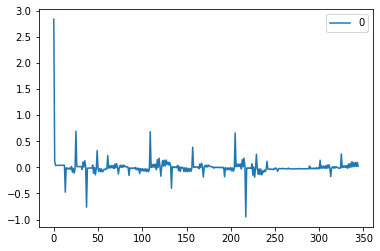

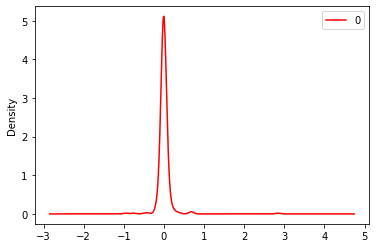

                0
count  345.000000
mean     0.005258
std      0.192666
min     -0.949268
25%     -0.028110
50%     -0.008032
75%      0.017347
max      2.843150


In [6]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde',color='red')
plt.show()
print(residuals.describe())

In [7]:
history = [x for x in train]
predictions = list()

In [8]:
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=11.440373, expected=11.507750
predicted=11.709200, expected=11.776500
predicted=11.978157, expected=12.045250
predicted=12.247231, expected=12.314000
predicted=12.516408, expected=12.165167
predicted=11.972731, expected=12.016333
predicted=11.831565, expected=11.867500
predicted=11.689615, expected=11.718667
predicted=11.547002, expected=11.569833
predicted=11.403807, expected=11.421000
predicted=11.260088, expected=11.272167
predicted=11.115895, expected=11.123333
predicted=10.971270, expected=10.974500
predicted=10.826253, expected=10.825667
predicted=10.680879, expected=10.676833
predicted=10.535184, expected=10.528000
predicted=10.389199, expected=10.442333
predicted=10.365342, expected=10.356667
predicted=10.280900, expected=10.271000
predicted=10.196350, expected=10.185333
predicted=10.111706, expected=10.099667
predicted=10.026975, expected=10.014000
predicted=9.942167, expected=9.928333
predicted=9.857288, expected=9.842667
predicted=9.772344, expected=9.757000
predic

In [9]:
rmse_model_ARIMA= np.sqrt(metrics.mean_squared_error(test, predictions))
rmse_model_ARIMA

0.04949519810139517

# Compare the results 

In [10]:
df = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea",'rmse_ses_model','rmse_hw_model','rmse_hwe_model_add_add','rmse_model_mul_add','rmse_ARIMA_model']),"RMSE_Values":pd.Series([rmse_linear_model,rmse_exp,rmse_quad_model,rmse_add_sea,rmse_add_sea_quad,rmse_Mul_sea,rmse_Mul_add_sea,rmse_ses,
rmse_hw,rmse_hwe_add_add,rmse_hwe_mul_add,rmse_model_ARIMA])}
table_rmse=pd.DataFrame(df)
table_rmse.sort_values(['RMSE_Values'])

NameError: name 'rmse_linear_model' is not defined

# Building ARIMA model for full dataset

In [5]:
final_model= ARIMA(data1, order=(10,0,2))
final_model= final_model.fit(disp=0)

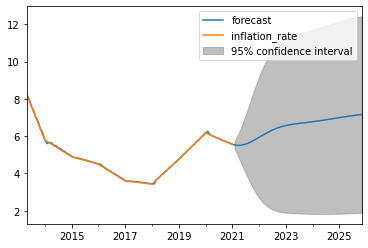

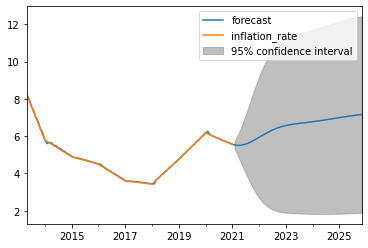

In [13]:
forecast=final_model.forecast(steps=10)[0]
final_model.plot_predict(400, 550)

In [14]:
pred=final_model.predict(start='2021-01-31',end='2021-12-31',typ='levels')

In [15]:
print(pred)

2021-01-31    5.566553
2021-02-28    5.528038
2021-03-31    5.509606
2021-04-30    5.510404
2021-05-31    5.519950
2021-06-30    5.545417
2021-07-31    5.577825
2021-08-31    5.623189
2021-09-30    5.675362
2021-10-31    5.736122
2021-11-30    5.801152
2021-12-31    5.870209
Freq: M, dtype: float64


<AxesSubplot:>

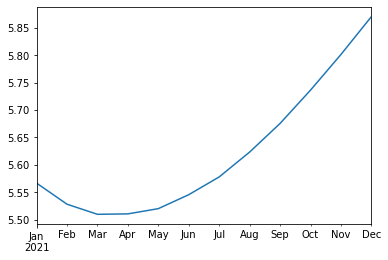

In [16]:
pred.plot()

In [20]:
from sklearn.pipeline import Pipeline
import pickle

In [21]:
filename = 'finalized_model.sav'

In [22]:
pickle.dump(final_model, open(filename, 'wb'))